https://www.hackerearth.com/challenges/competitive/IIT-Madras-Sangam-ML-Hackathon-2019/machine-learning/predict-the-traffic-volume-1761f3b1/  

Score = 100 - mean__squared__error(actual values, predicted values)

## Initial Setup

In [ ]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
!pip install lightgbm==2.2.4
#!pip install tensorboardcolab
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2
#!pip install scikit-optimize==0.6

#Restart Runtime

## Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(20.0, 6.0))

import shap
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit #, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

#import sklearn.svm as svm
#import sklearn.neighbors as knn

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error #, mean_squared_log_error

In [ ]:
np.array([["TN", "FP"],["FN", "TP"]])

In [ ]:
# Change id only
train_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1R7zW_npN61DR8Zp8vxTnw1MXeM4EEf2E", parse_dates = ["date_time"])
test_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=17mPXhdEz4h69fTQhZXWcm5WQ52tpQ3Ll", parse_dates = ["date_time"])

### Manipulation

Mean Encoding.  
Divide and Multiply columns.  


Time Series  
Date parts  
Lag values  
Difference between dates 

In [ ]:
# train_data.query("temperature > 0")["temperature"].mean() # 280.15259564315926

# visibility and dew point scale of 1 to 9

In [ ]:
def clean_data(dataset):
    
    op_set_1 = (dataset
                    .assign(is_holiday = np.where(dataset.is_holiday == "None", 0, 1 ))
                    .assign(temperature = dataset.temperature.replace(0, 280.15))
                    .assign(weather_type = dataset.weather_type.str.lower())
                    .assign(weather_description = dataset.weather_description.str.lower())
                    .assign(month = dataset.date_time.dt.month)
                    #.assign(monthName = dataset.date_time.dt.month_name())
                    .assign(week = dataset.date_time.dt.week)
                    .assign(day = dataset.date_time.dt.day)
                    #.assign(dayName = dataset.date_time.dt.day_name())
                )
    
    return op_set_1

train_data = clean_data(train_data_og)
train_data.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume,month,week,day
0,2012-10-02 09:00:00,0,121,89,2,329,1,1,288.28,0.0,0.0,40,clouds,scattered clouds,5545,10,40,2
1,2012-10-02 10:00:00,0,178,67,3,330,1,1,289.36,0.0,0.0,75,clouds,broken clouds,4516,10,40,2
2,2012-10-02 11:00:00,0,113,66,3,329,2,2,289.58,0.0,0.0,90,clouds,overcast clouds,4767,10,40,2
3,2012-10-02 12:00:00,0,20,66,3,329,5,5,290.13,0.0,0.0,90,clouds,overcast clouds,5026,10,40,2
4,2012-10-02 13:00:00,0,281,65,3,329,7,7,291.14,0.0,0.0,75,clouds,broken clouds,4918,10,40,2


In [ ]:
sub_data = clean_data(test_data_og)
sub_data.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,month,week,day
0,2017-05-18 00:00:00,0,73,63,1,27,4,4,285.15,0.0,0,90,rain,moderate rain,5,20,18
1,2017-05-18 00:00:00,0,251,63,1,27,4,4,285.15,0.0,0,90,mist,mist,5,20,18
2,2017-05-18 00:00:00,0,75,56,1,0,1,1,285.15,0.0,0,90,drizzle,light intensity drizzle,5,20,18
3,2017-05-18 01:00:00,0,98,56,1,351,2,2,284.79,0.0,0,90,rain,heavy intensity rain,5,20,18
4,2017-05-18 01:00:00,0,283,56,1,351,1,1,284.79,0.0,0,90,mist,mist,5,20,18


In [ ]:
print(np.min(train_data_og.date_time), np.max(train_data_og.date_time)) 
print(np.min(test_data_og.date_time), np.max(test_data_og.date_time)) # approx 1 yr and 4 months

2012-10-02 09:00:00 2017-05-17 23:00:00
2017-05-18 00:00:00 2018-09-30 23:00:00


## EDA

seaborn or pandas plot as required.  
verify labels truth - a new column called sample_weights may be helpful for noisy data.

### Distribution

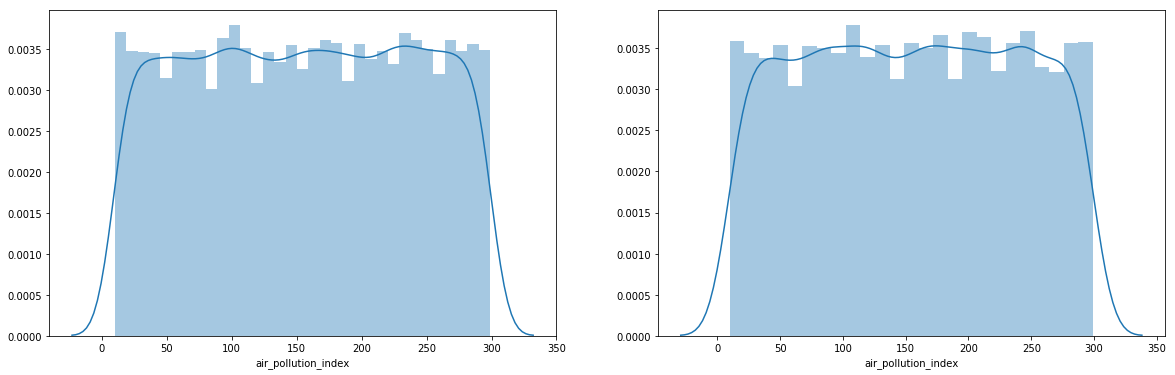

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.air_pollution_index)
plt.subplot(1,2,2)
sns.distplot(test_data_og.air_pollution_index)
plt.show()

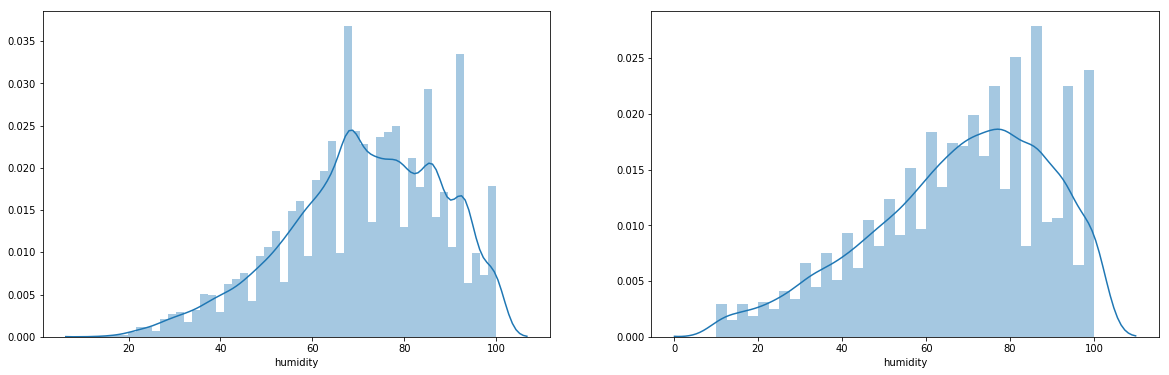

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.humidity)
plt.subplot(1,2,2)
sns.distplot(test_data_og.humidity)
plt.show()

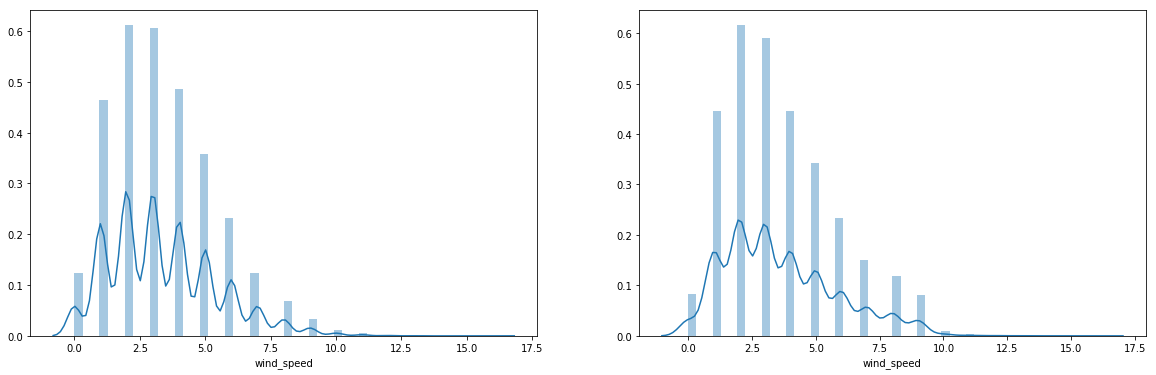

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.wind_speed)
plt.subplot(1,2,2)
sns.distplot(test_data_og.wind_speed)
plt.show()

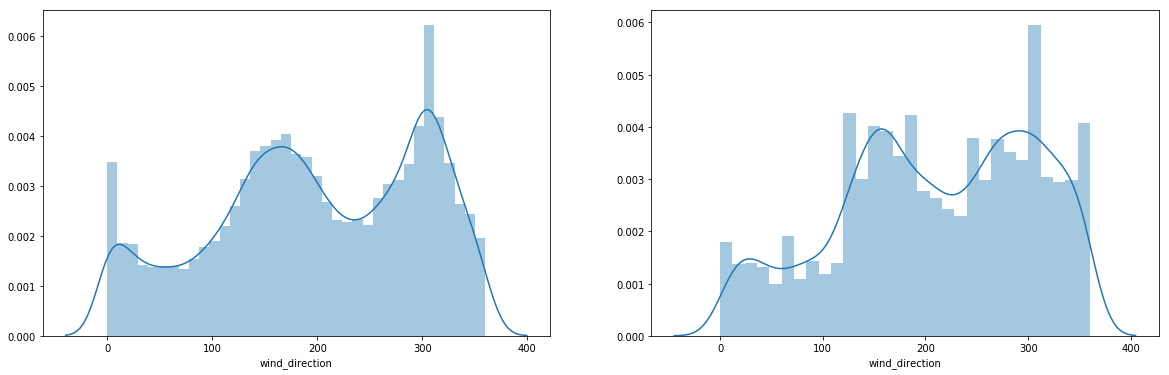

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.wind_direction)
plt.subplot(1,2,2)
sns.distplot(test_data_og.wind_direction)
plt.show()

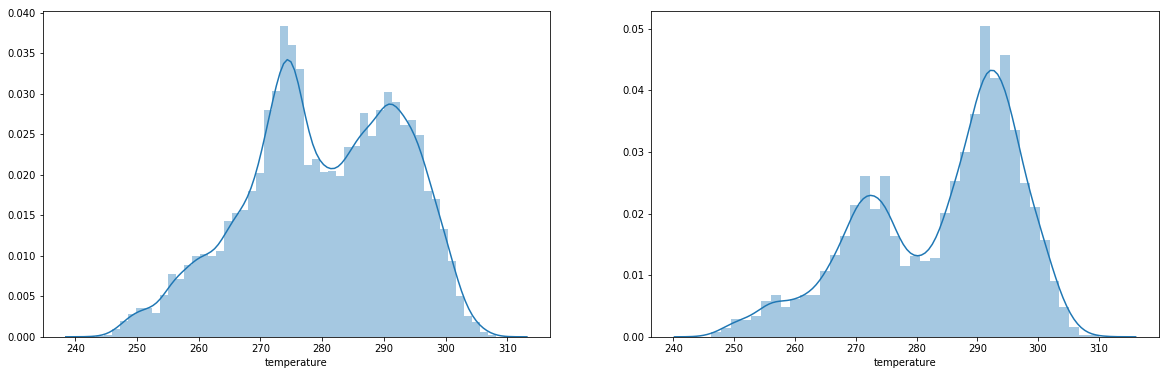

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.query('temperature > 0').temperature)
plt.subplot(1,2,2)
sns.distplot(test_data_og.temperature)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


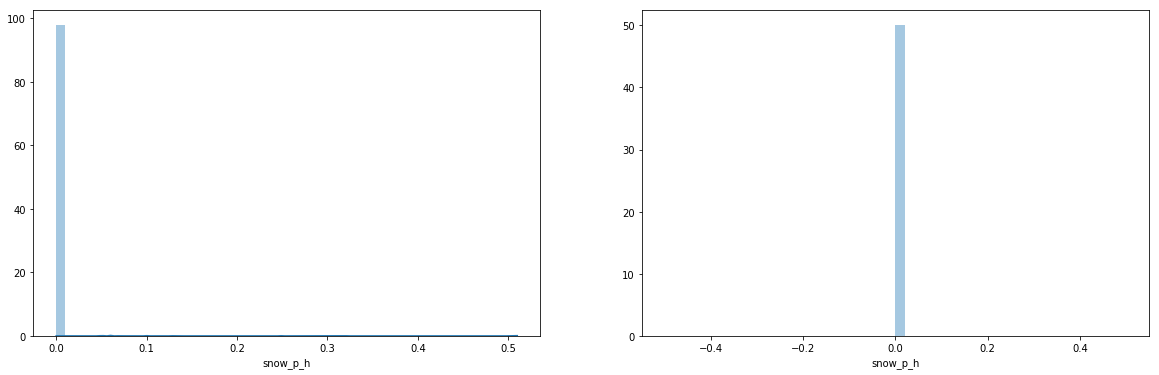

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.snow_p_h)
plt.subplot(1,2,2)
sns.distplot(test_data_og.snow_p_h)
plt.show()

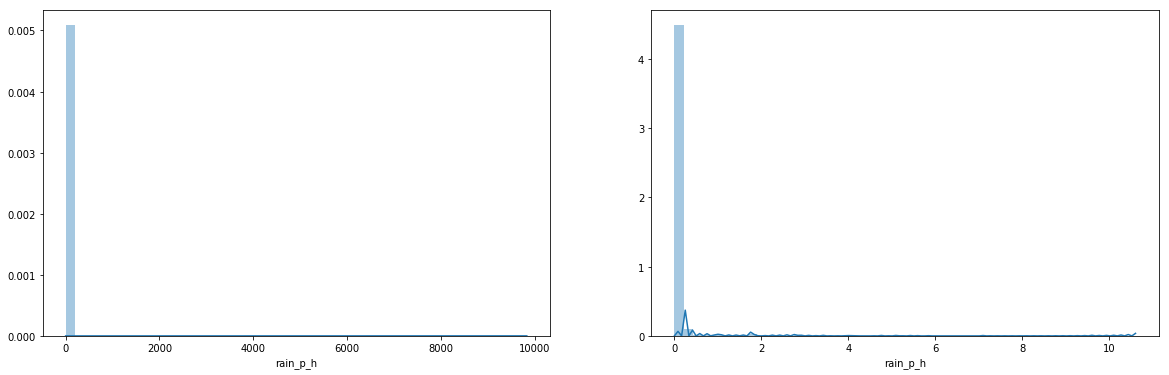

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.rain_p_h)
plt.subplot(1,2,2)
sns.distplot(test_data_og.rain_p_h)
plt.show()

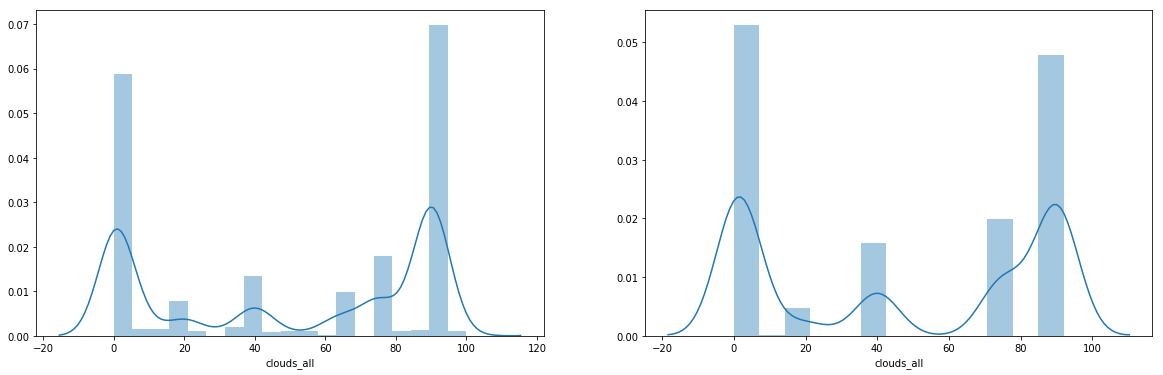

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data_og.clouds_all)
plt.subplot(1,2,2)
sns.distplot(test_data_og.clouds_all)
plt.show()

### Univariate

Distributions, Outliers

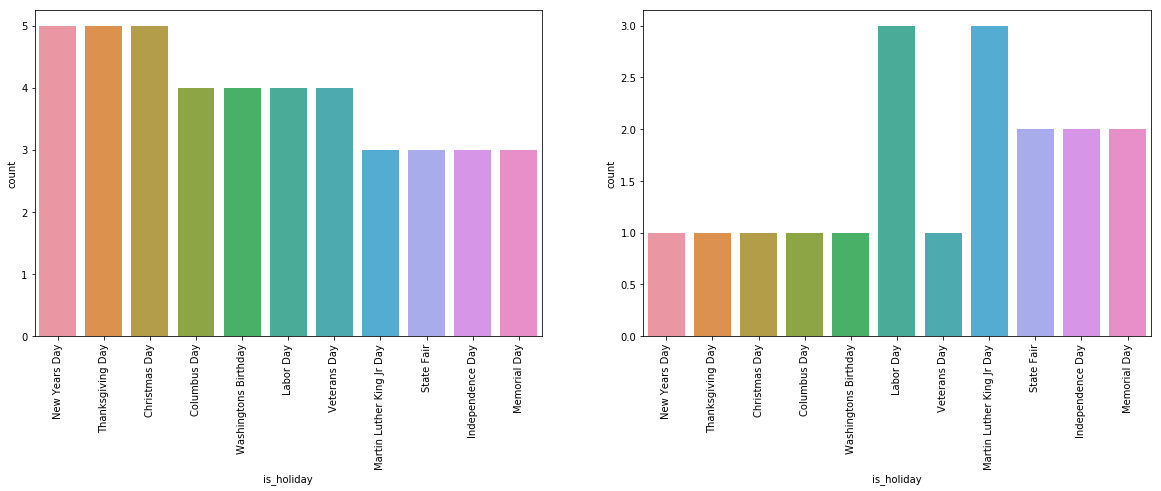

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data_og.query("is_holiday != 'None'")['is_holiday'], order = train_data_og.query("is_holiday != 'None'").is_holiday.value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(test_data_og.query("is_holiday != 'None'")['is_holiday'], order = train_data_og.query("is_holiday != 'None'").is_holiday.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

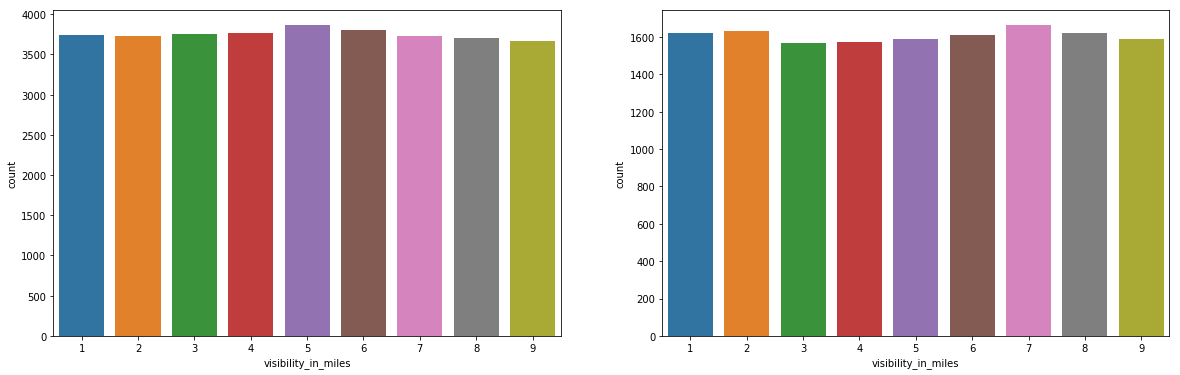

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data_og.visibility_in_miles)
plt.subplot(1,2,2)
sns.countplot(test_data_og.visibility_in_miles)
plt.show()

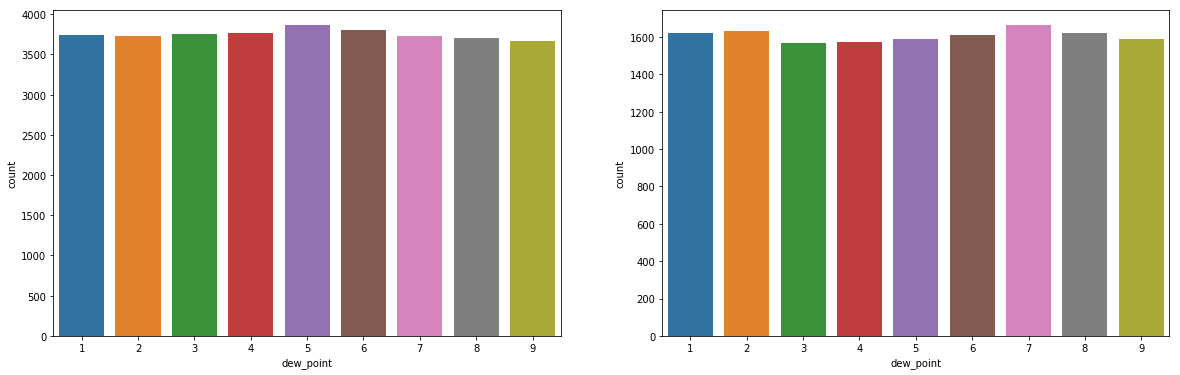

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data_og.dew_point)
plt.subplot(1,2,2)
sns.countplot(test_data_og.dew_point)
plt.show()

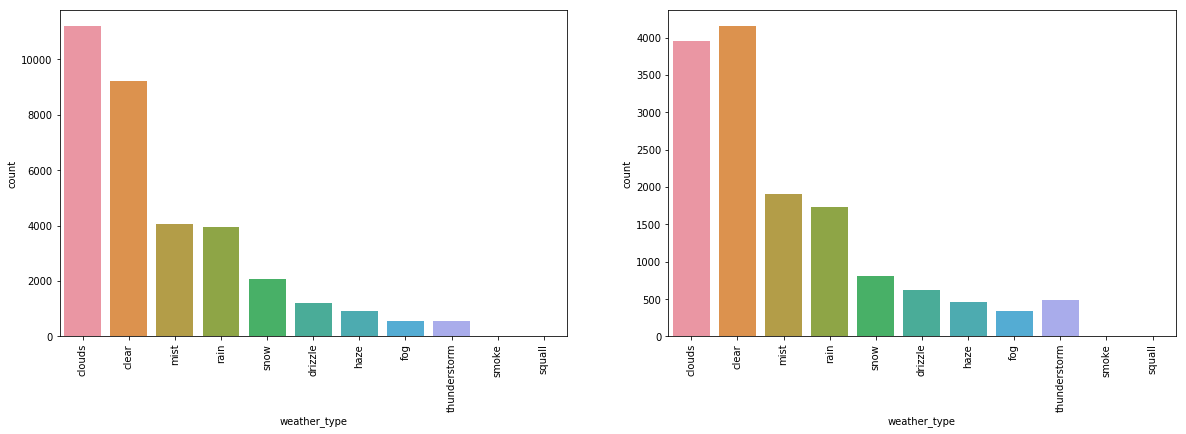

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data_og.weather_type.str.lower(), order = train_data_og.weather_type.str.lower().value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(test_data_og.weather_type.str.lower(), order = train_data_og.weather_type.str.lower().value_counts().index)
plt.xticks(rotation = 90)
plt.show()

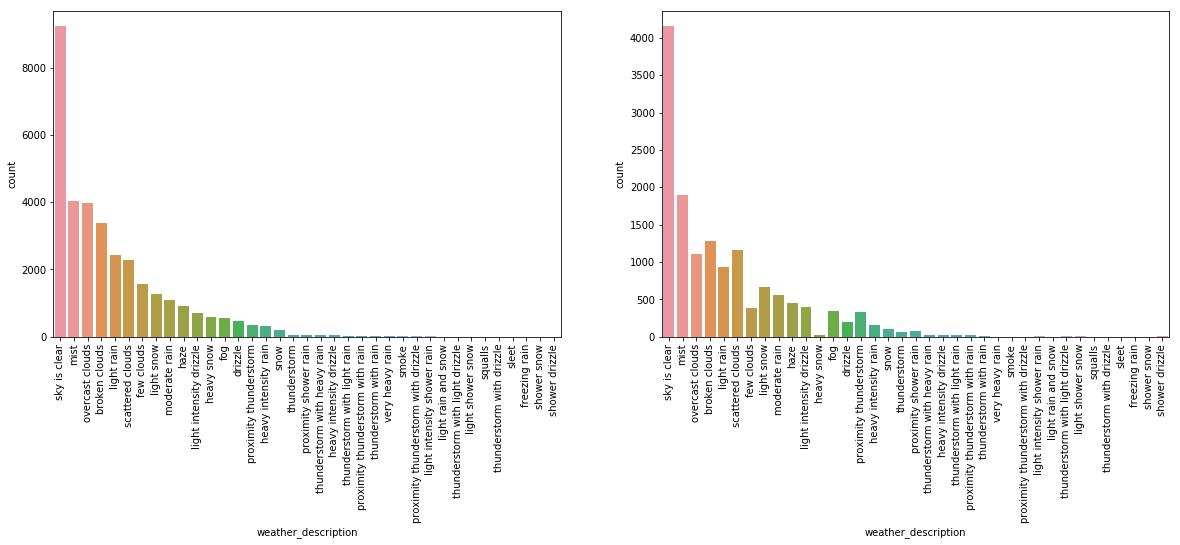

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data_og.weather_description.str.lower(), order = train_data_og.weather_description.str.lower().value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(test_data_og.weather_description.str.lower(), order = train_data_og.weather_description.str.lower().value_counts().index)
plt.xticks(rotation = 90)
plt.show()

### Bivariate

Comparision, corelation

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data.XXX, order = train_data.xxx.values_count().index )
plt.subplot(1,2,2)
sns.countplot(sub_data.XXX, order = [1,2,3,4])
plt.show()

### With sub_data

Submit pattern, cv on, splitted on

## Data Validation

Replace xxx with proper data  

1) Random split
2) Catogorical split
3) Time based split

In [ ]:
wholeset = pd.get_dummies(train_data)
subdataset = pd.get_dummies(sub_data)

trainset = wholeset.query("date_time < '2016-01-01' ")
testset = wholeset.query("date_time >= '2016-01-01' ")

X_train = wholeset.drop(['traffic_volume'], axis = 1)
y_train = wholeset["traffic_volume"]

X_test = testset.drop(['traffic_volume'], axis = 1)
y_test = testset["traffic_volume"]

X_sub = subdataset.copy()

#cat_train, cat_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["xxx"])

# X = pd.get_dummies(X) #, dummy_na = True
# X_sub = pd.get_dummies(sub_data)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["xxx"])

In [ ]:
print("Train set rows %s, cols %s and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))
print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Train set rows 33750, cols 63 and y is 33750
Test set rows 13406, cols 63 and y is 13406
Submission set rows 14454, cols 56 and y is to be predicted


In [ ]:
# # Run only if required

for x in set(X_train.columns) - set(X_sub.columns) :
    X_sub[x] = 0

X_sub = X_sub[X_train.columns]
    
print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Submission set rows 14454, cols 63 and y is to be predicted


### Validataion EDA

## Modeling

For Regression verify distribution.  
For Classification verify confusion matrix.  
Use 10 fold cross validation to verify final model.  

### Submission Part

Ensure that model is trained on whole set

### XGBoost

Monitor metric performance on both train and test.  

In [ ]:

xgb_model = xgb.XGBClassifier(learning_rate=0.01, scale_pos_weight = weight, n_estimators = 100000)
xgb_model.fit(X_train, y_train, eval_metric = "xxx", eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 1000, early_stopping_rounds=10)

#joblib.dump(xgb_model, "drive/My Drive/PyColab Work/xxx/xgb_model.sav")
#confusion_matrix(y_train, xgb_model.predict(X_train))

In [ ]:
100 - np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train)))

In [ ]:
100 - np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))

In [ ]:
groups = X_train[["Transmission", "Fuel_Type_CNG", "Fuel_Type_Diesel", "Fuel_Type_Electric", "Fuel_Type_LPG", "Fuel_Type_Petrol"]]

cross_val_score(xgb_model, X_train, y_train, cv = 5, groups = groups) # Add Fuel Type as well

In [ ]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[0:nsize,:])
b = shap.summary_plot(shap_values, X_test.iloc[0:nsize,:])

#### Hyperparameter Tuning

Draw appropriate graph to understand impact of two hyperparameters.  
eg: rounds to maxdepth can give an idea where it overfits.

##### GridSearchCV

In [ ]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, n_jobs = 4, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

##### Skopt

In [ ]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# set up hyperparameter space
space = [Integer(3, 50, name='max_depth'),
         Integer(8, 200, name='n_estimators'),
         Integer(3, 50, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate')]

regressor = xgb.XGBRegressor()

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    return -np.mean(cross_val_score(regressor, X_train, y_train, cv=5, n_jobs=1, scoring='neg_mean_squared_error'))

In [ ]:
reg_gp = gp_minimize(objective, space, verbose=False)

print('best score: {}'.format(reg_gp.fun))

print('best params:')
print('        max_depth: {}'.format(reg_gp.x[0]))
print('     n_estimators: {}'.format(reg_gp.x[1]))
print(' min_child_weight: {}'.format(reg_gp.x[2]))
print('    learning_rate: {}'.format(reg_gp.x[3]))

In [ ]:
import skopt.plots
skopt.plots.plot_convergence(reg_gp)

In [ ]:
skopt.plots.plot_evaluations(reg_gp, bins = 20)
plt.show()

In [ ]:
skopt.plots.plot_objective(reg_gp)
plt.show()

##### Hyperopt

### LightGBM
Inbuilt Categorical features

In [ ]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100000)
lgbm_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
lgbm_engine = lgb.LGBMRegressor()
lgbm_params = {'max_depth' : [17], 'learning_rate' : [0.05], 'n_estimators': [100000],  'min_child_samples' : [3], 'num_leaves' : [40], 'min_child_weight' : [0.001], 
               'min_split_gain' : [0], 'colsample_bytree' : [0.3], 'reg_alpha' : [0], 'reg_lamba' : [0], 'importance_type' : ['split'] }

lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 4, n_jobs = 4, verbose = 0)
lgbm_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)
#print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, lgbm_grid.predict(X_test)) ) )

### CatBoost

Inbuilt Categorical features  

The cat.cv - inbuilt cross validation gives cross validated result on each iterations.   
The only hyperparameter we can select from in built cv is no of iteration.  
Try sklearn cv type with for loop for cv score or skopt or hyperopt module.  

In [ ]:
cat_train = X_train.copy()
cat_test = X_test.copy()

In [ ]:
from catboost import CatBoostRegressor, Pool
categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

cat_model = CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
cat_model.fit(cat_train, y_train, eval_set = (cat_test, y_test), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=10)

#print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
#np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3775.5800536	test: 3737.4043793	best: 3737.4043793 (0)	total: 42.4ms	remaining: 1h 10m 36s
1000:	learn: 1870.1206142	test: 1839.8567742	best: 1839.8567742 (1000)	total: 42.8s	remaining: 1h 10m 28s
2000:	learn: 1823.2239130	test: 1788.4012534	best: 1788.4012534 (2000)	total: 1m 29s	remaining: 1h 13m 5s
3000:	learn: 1792.7936943	test: 1756.7627449	best: 1756.7627449 (3000)	total: 2m 19s	remaining: 1h 15m 12s
4000:	learn: 1772.6810887	test: 1733.8589669	best: 1733.8589669 (4000)	total: 3m 18s	remaining: 1h 19m 32s
Buffered data was truncated after reaching the output size limit.

In [ ]:
mean_squared_error(y_train, cat_model.predict(X_train))

3448590.0524789486

In [ ]:
mean_squared_error(y_test, cat_model.predict(X_test))

3927073.507803093

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(cat_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

CatBoostError: ignored

#### Hyperparamter Tuning

In [ ]:
cat_engine = CatBoostRegressor()
cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)
cat_grid.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

### SVM

Apply scaling

In [ ]:
#%%script false

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling only on numeric data.
svmpipe = Pipeline([ ( "std", StandardScaler() ), ("mimax", MinMaxScaler()) , ( "svm", SVR(gamma = 'scale', kernel = 'rbf', C = 1.5, epsilon = 0.1, max_iter=-1) ) ])
svmpipe.fit(X_train, y_train)

#np.sqrt( -cross_val_score(svmpipe, X_train.astype(float), y_train.astype(float), cv = 5, scoring = "neg_mean_squared_error") )
np.sqrt( mean_squared_error(y_test, svmpipe.predict(X_test))) 

#### SHAP

#### Hyperparamter Tuning

### KNN

Apply scaling

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#Scaling on numeric data only
neigh = KNeighborsRegressor(n_neighbors=5)
knnpipe = Pipeline([ ( "std", StandardScaler() ), ("minmax", MinMaxScaler() ), ( "knn", neigh ) ])

#scale data
knnpipe.fit(X_train, y_train) 
print( np.sqrt( -cross_val_score(neigh, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#np.sqrt(mean_squared_error(y_test, neigh.predict(X_test)))

#### SHAP

#### Hyperparamter Tuning

### Keras

Apply scaling

In [ ]:
#!pip install tensorboardcolab
# Apply scaling

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
#tbc=TensorBoardColab()

model2 = Sequential()
model2.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(30, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.10))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.10))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.fit(X_train, y_train, epochs = 18, verbose = 0) #callbacks=[TensorBoardColabCallback(tbc)]
pd.DataFrame( {"Actual" : np.exp(y_test), "Predict" : np.exp(model2.predict(X_test)[0:,0])} ).describe()

#### SHAP

#### Hyperparamter Tuning

### Linear

inludes - Logistic  
Panelty - Ridge, Lasso and ElasticNet  


#### SHAP

#### Hyperparamter Tuning

## Stacking

In [ ]:
#mlextend